**1. Environment**

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
#import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
#import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
#from scipy.interpolate import griddata # Other package for regridding

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 187 GB / available: 129 GB / percent used: 31.2 %


**2. Geographical coordinates**

(<matplotlib.lines.Line2D at 0x7f8516fb3e20>,)

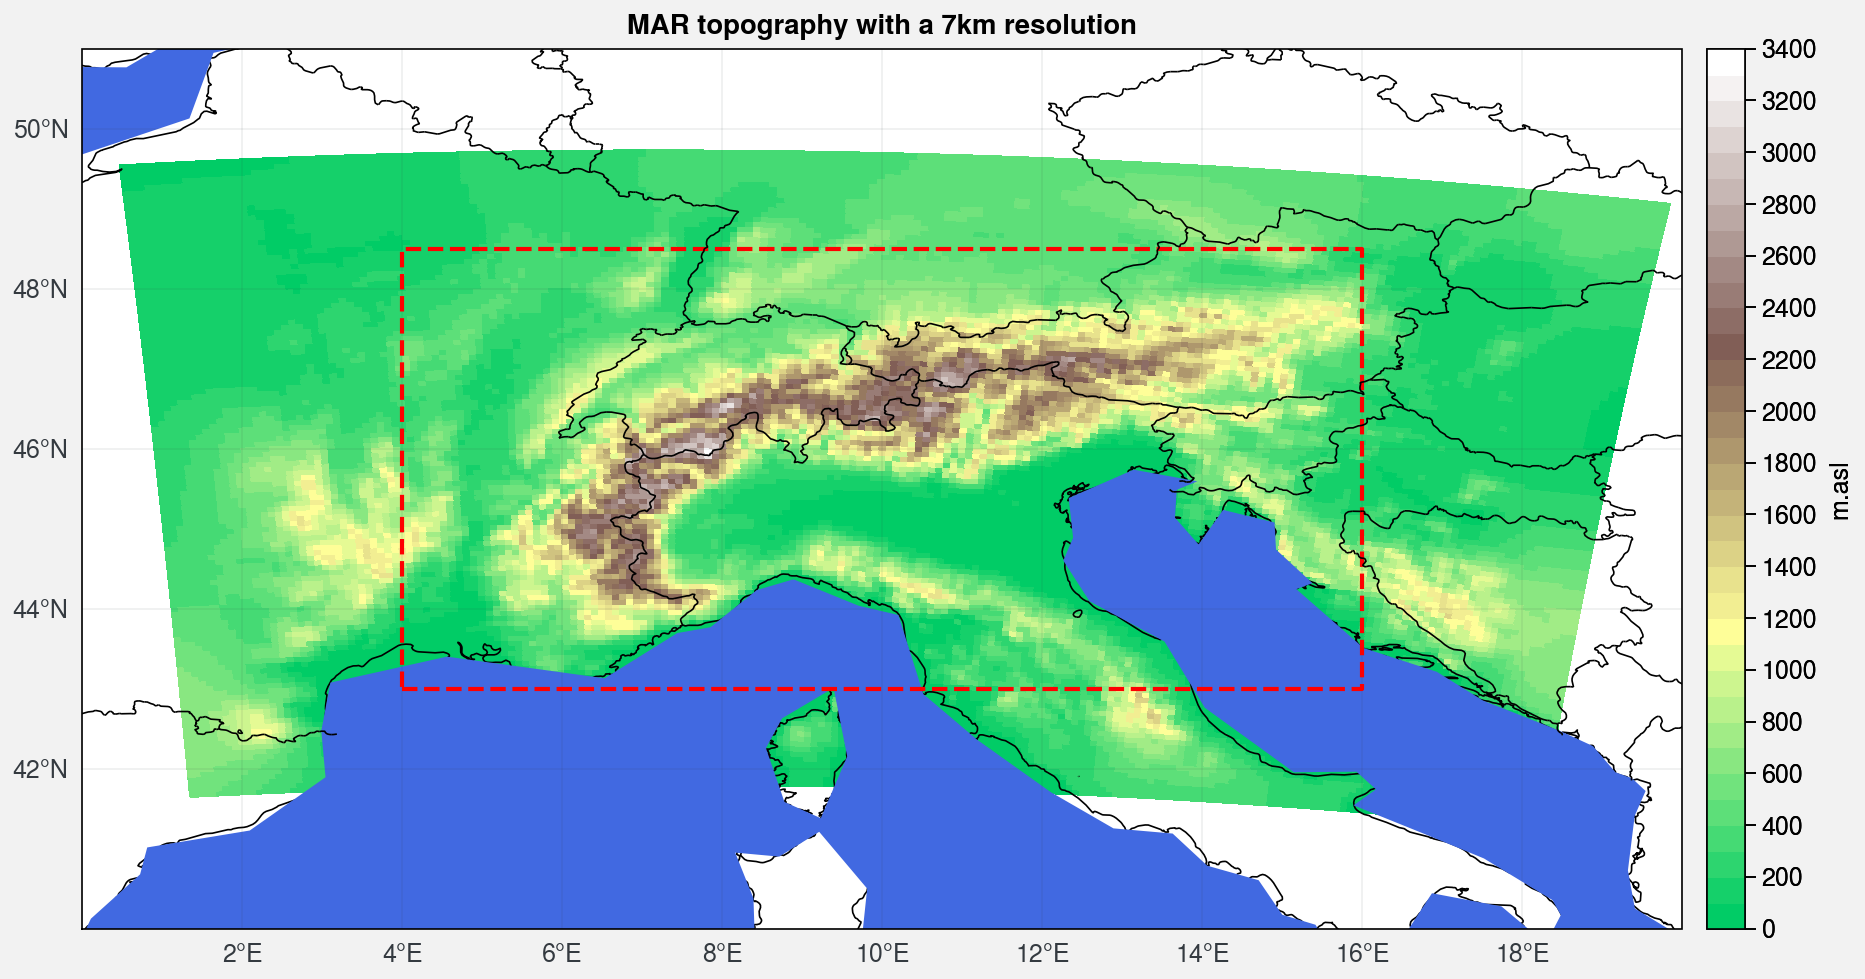

In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
ax.format(**normal_format)
ax.format(ocean=True,oceancolor='royalblue',suptitle='MAR topography with a 7km resolution', latlim=[40.,51.],lonlim=[0.,20.])

ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

**3 Seasonal means**

In [3]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [4]:
first_year = 1902
last_year = 1910
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    if year> first_year:
        seasonal_mean += seasonal_mean_year
    else:
        seasonal_mean = xr.DataArray.copy(seasonal_mean_year)
seasonal_mean /= (last_year-first_year+1)

print(seasonal_mean.shape, seasonal_mean.season.data)

1902 1903 1904 1905 1906 1907 1908 1909 1910 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


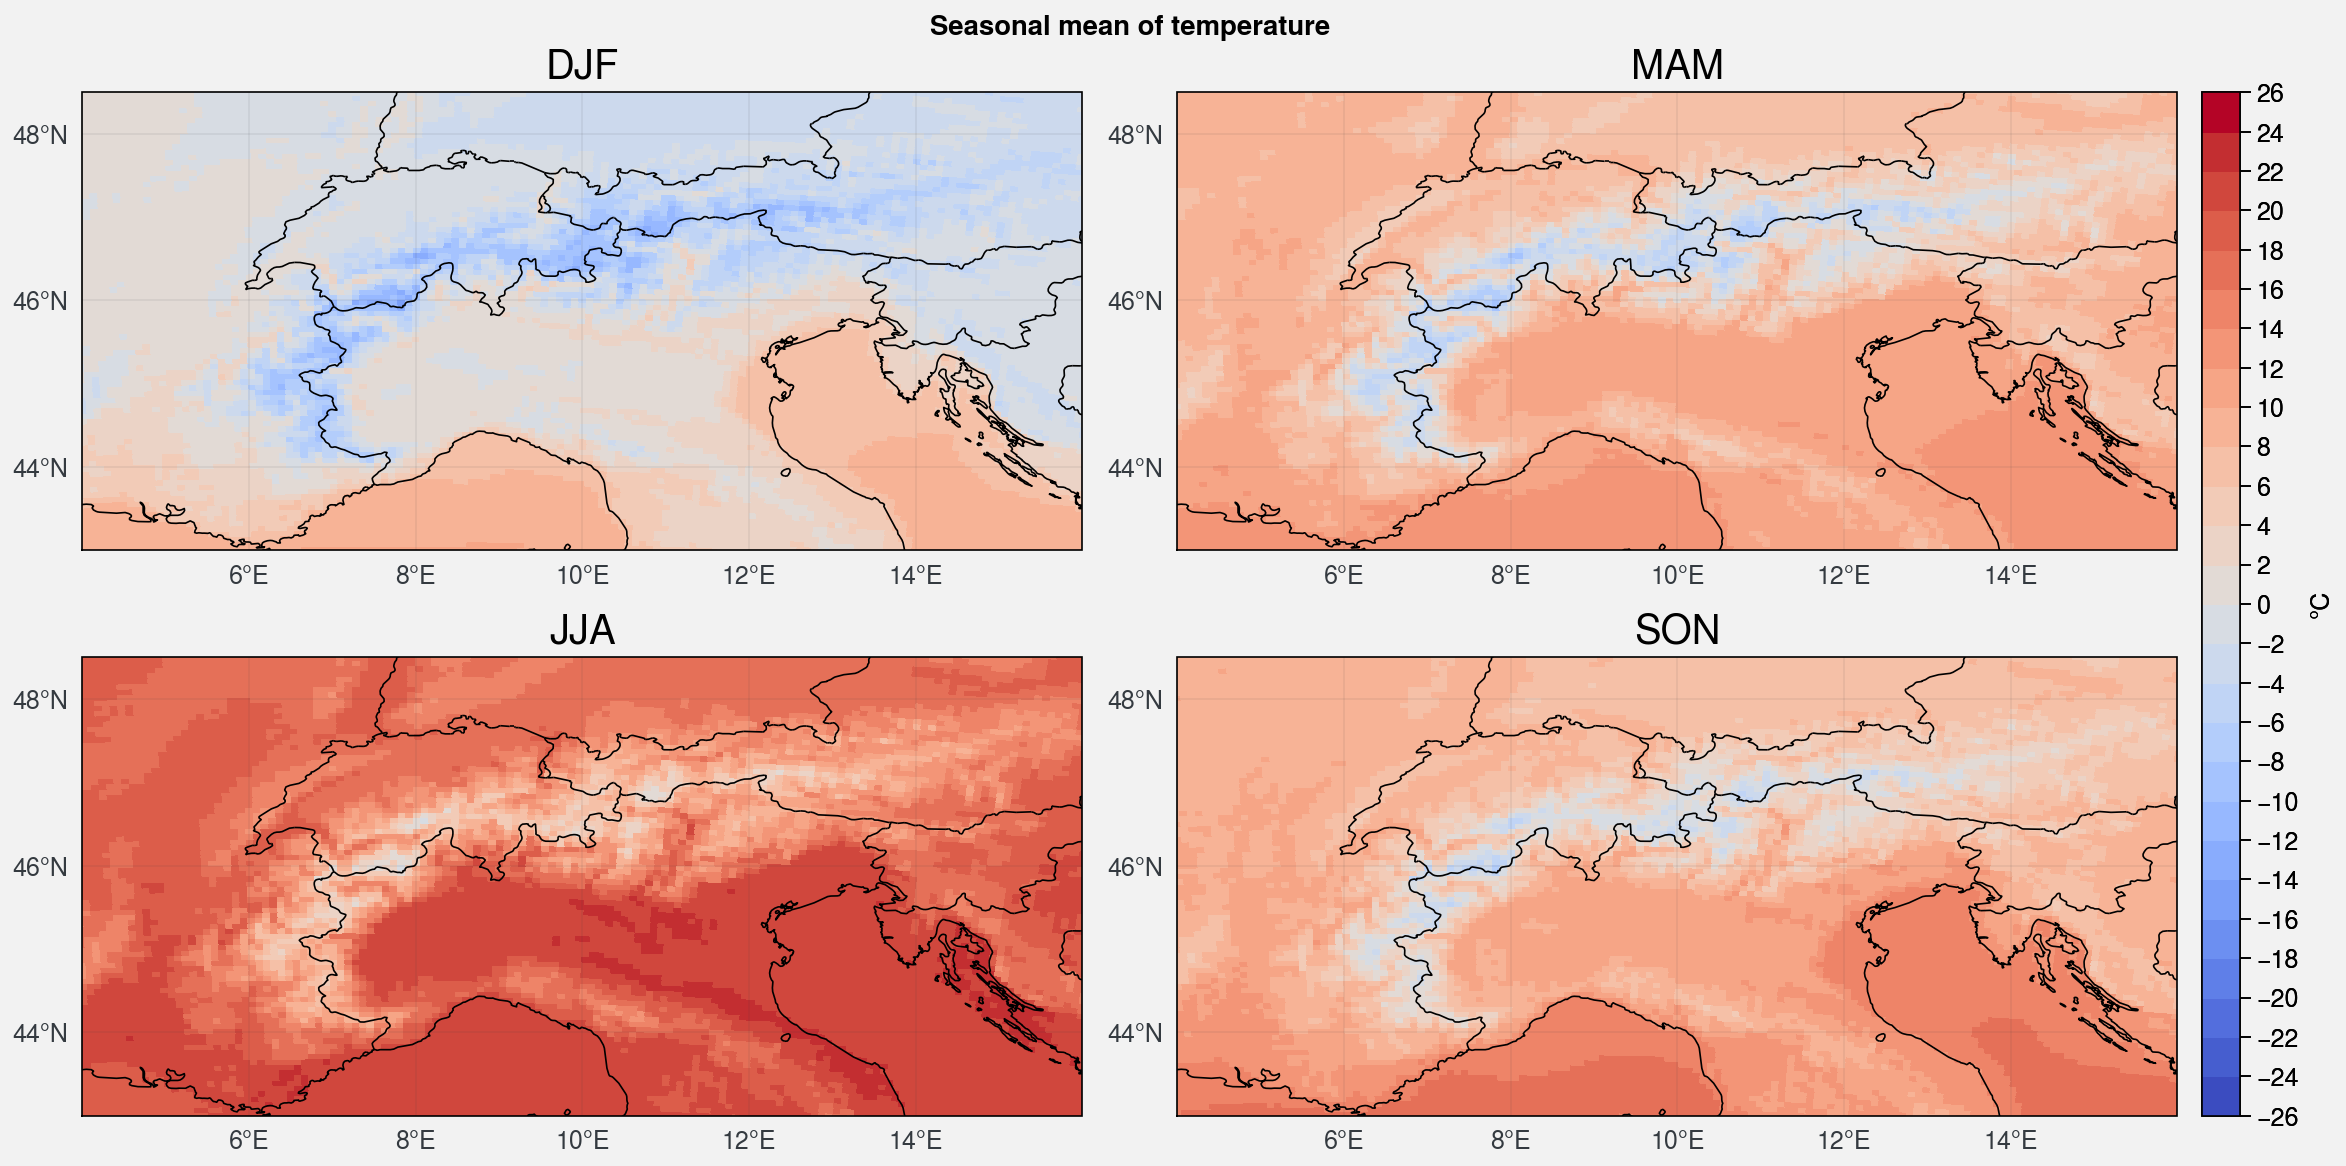

In [5]:
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh( ds.LON,ds.LAT, seasonal_mean[i,:,:], levels=np.arange(-26,28,2),cmap='coolwarm')
    ax.format(title=seasonal_mean.season.data[i],titlesize='20px')  
f.colorbar(m, label= '°C')
axs.format(**normal_format,suptitle="Seasonal mean of temperature")

**4 Extremes**

In [6]:
first_year = 1902
last_year = 1910
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.TTmax.'+str(year)+'.nc')
    max_year=(ds_T.TTmax.isel(atmlay=0)).max(axis=0)
    if year> first_year:
        mean_max += max_year
    else:
        mean_max = xr.DataArray.copy(max_year)
mean_max /= (last_year-first_year+1)

print(mean_max.shape)

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.TTmin.'+str(year)+'.nc')
    min_year=(ds_T.TTmin.isel(atmlay=0)).min(axis=0)
    if year> first_year:
        mean_min += min_year
    else:
        mean_min = xr.DataArray.copy(min_year)
mean_min /= (last_year-first_year+1)

print(mean_min.shape)

1902 1903 1904 1905 1906 1907 1908 1909 1910 (126, 201)
1902 1903 1904 1905 1906 1907 1908 1909 1910 (126, 201)


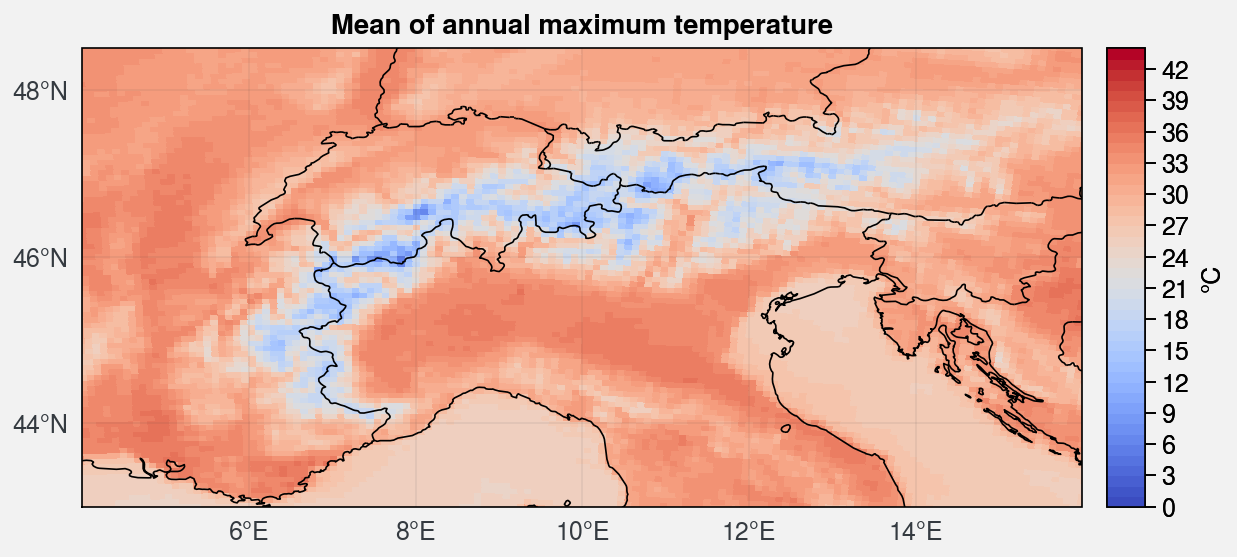

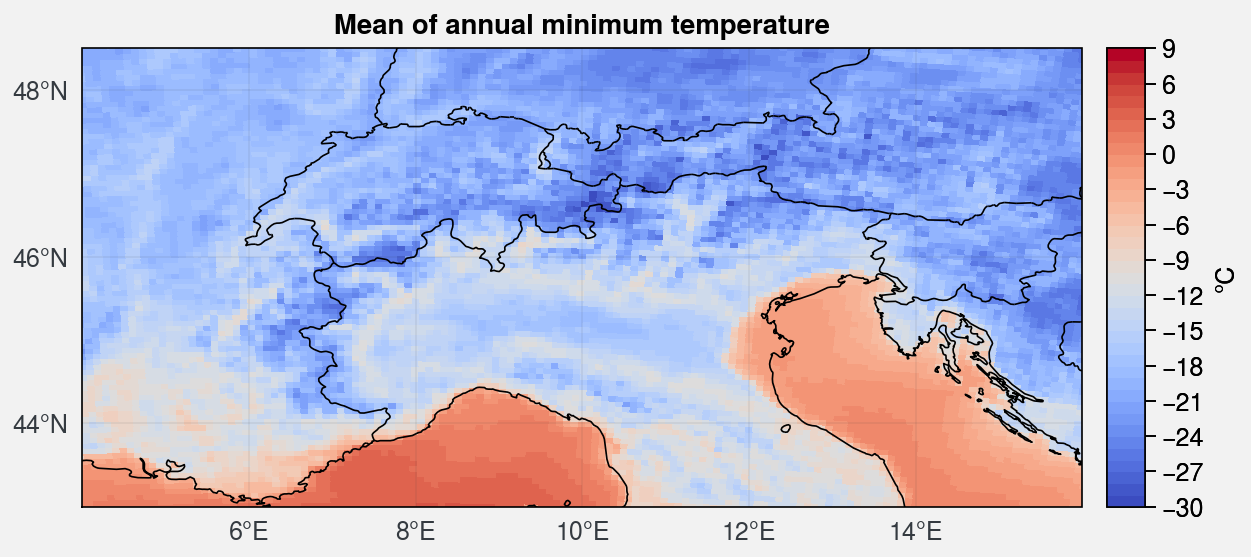

In [7]:
f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5)
m = ax.pcolormesh(ds.LON,ds.LAT,mean_max, levels=np.arange(0,45,1), cmap='coolwarm'    )
f.colorbar(m, label= '°C')
ax.format(**normal_format,suptitle="Mean of annual maximum temperature")

f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5)
m = ax.pcolormesh( ds.LON,ds.LAT,mean_min, levels=np.arange(-30,10,1), cmap='coolwarm'    )
f.colorbar(m, label= '°C')
ax.format(**normal_format,suptitle="Mean of annual minimum temperature")